# Разные стили с использованием StyleGAN-NADA

**Цель**   
Обучить и сохранить четыре разные модели StyleGAN-NADA, адаптированные к различным стилям, используя только текстовые описания без реальных изображений целевого домена.

**Идея метода**  

StyleGAN-NADA (Non-Adversarial Domain Adaptation) — это метод, который позволяет адаптировать предобученные генеративные модели StyleGAN2 к новым визуальным стилям, используя только текстовые описания.

**Как работает адаптация**  

**Ключевая идея:** Используем семантическое направление в пространстве CLIP между **текстовыми описаниями** исходного и целевого доменов, чтобы направлять адаптацию генератора.

**Математическая формулировка:**

```
L_dir = 1 - cos(E(G(z_t)) - E(G(z_s)), E(T_target) - E(T_source))
```

где:
- **E()** — энкодер CLIP
- **G()** — генератор StyleGAN2  
- **z_s, z_t** — латентные векторы в w-пространстве
- **T_source, T_target** — текстовые промпты исходного и целевого доменов

Мы хотим, чтобы направление изменения изображений (от исходного к стилизованному) соответствовало направлению изменения текстовых описаний. Схожесть направлений в пространстве CLIP измеряется косинусным расстоянием.

**Целевые стили**  
Мы адаптируем базовую модель ffhq (1024×1024) к четырем стилям:
- аниме
- скетч
- Джокер
- картина маслом

## Настройки и импорты

In [1]:
import os
import sys

pretrained_model_dir = os.path.join("/content", "models")

# для локального запуска раскомментировать:
# pretrained_model_dir = "models"

os.makedirs(pretrained_model_dir, exist_ok=True)

stylegan_ada_dir = os.path.join("/content", "stylegan_ada")
stylegan_nada_dir = os.path.join("/content", "stylegan_nada")

# для локального запуска раскомментировать:
# stylegan_ada_dir = "stylegan_ada"
# stylegan_nada_dir = "stylegan_nada"

output_dir = os.path.join("/content", "output")

# для локального запуска раскомментировать:
# output_dir = "output"

os.makedirs(output_dir, exist_ok=True)

In [2]:
!git clone https://github.com/NVlabs/stylegan2-ada/ $stylegan_ada_dir
!git clone https://github.com/rinongal/stylegan-nada.git $stylegan_nada_dir

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip -q
!unzip -q -o ninja-linux.zip -d /usr/local/bin/
!chmod +x /usr/local/bin/ninja

!pip install -q ftfy regex tqdm imageio gdown
!pip install -q git+https://github.com/openai/CLIP.git

sys.path.append(stylegan_nada_dir)
sys.path.append(os.path.join(stylegan_nada_dir, "ZSSGAN"))

print("Зависимости установлены")

Cloning into '/content/stylegan_ada'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74 (from 1)
Receiving objects: 100% (74/74), 1.28 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Cloning into '/content/stylegan_nada'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 380 (delta 62), reused 78 (delta 41), pack-reused 255 (from 1)
Receiving objects: 100% (380/380), 23.54 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (111/111), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Зависимости установлены


In [3]:
import torch

print("Загрузка модели ffhq...")

source_model_type = 'ffhq'
file_name = "ffhq.pt"
pt_file_name = file_name

dataset_sizes = {
    "ffhq": 1024,
    "cat": 512,
    "dog": 512,
    "church": 256,
    "horse": 256,
    "car": 512,
}

ffhq_model_url = "https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT"
model_path = os.path.join(pretrained_model_dir, file_name)

if not os.path.isfile(model_path):
    !gdown -O "{model_path}" "{ffhq_model_url}"
else:
    print("Модель ffhq уже загружена")

if os.path.isfile(model_path):
    checkpoint = torch.load(model_path, map_location='cpu')
    print("Модель успешно загружена")
else:
    print("Модель не найдена")

Загрузка модели ffhq...
Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=d2bc896a-ea92-45f8-b499-6d8c599d7402
To: /content/models/ffhq.pt
100% 381M/381M [00:05<00:00, 75.3MB/s]
Модель успешно загружена


## Обучение модели

In [4]:
from ZSSGAN.model.ZSSGAN import ZSSGAN
import numpy as np
import torch
from tqdm import tqdm
from ZSSGAN.utils.training_utils import mixing_noise
from ZSSGAN.utils.file_utils import save_images
from argparse import Namespace
import os
from PIL import Image
import torchvision
from torchvision.utils import save_image
import json
import copy
import matplotlib.pyplot as plt

print(f"Torchvision version: {torchvision.__version__}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Torchvision version: 0.24.0+cu126
Using device: cuda


In [5]:
source_class = "Photo"
target_classes = [
    "anime character, Japanese anime style, cel-shaded, vibrant colors, large expressive eyes",
    "sketch, pencil drawing, hand-drawn, monochrome, artistic sketch, black and white drawing",
    "the Joker from Batman, green hair, white face, red lips, creepy smile, makeup",
    "oil painting, brush strokes, artistic, textured, classical painting style, canvas texture"
]

# только text-to-image режим
style_image_dir = ""
target_img_list = None
improve_shape = False

experiment_names = ["anime_style", "sketch_style", "joker_style", "oil_painting_style"]

model_choice = ["ViT-B/32", "ViT-B/16", "ViT-L/14"]
model_weights = [0.4, 0.1, 0.5]

if improve_shape:
    model_weights[1] = 1.0

training_iterations = 600
output_interval = 50
batch_size = 2
n_sample = 4
lr = 0.002
mixing = 0.9 if improve_shape else 0.0
sample_truncation = 0.7
auto_layers_k = 0
size = dataset_sizes[source_model_type]
save_interval = 0

In [6]:
# исправленная функция save_images из оригинального кода для работы с новой версией torchvision
def save_images_fixed(images: torch.Tensor, output_dir: str, file_prefix: str, nrows: int, iteration: int) -> None:
    import torchvision.utils as utils
    import os

    os.makedirs(output_dir, exist_ok=True)

    if torchvision.__version__ >= '0.13.0':
        grid = utils.make_grid(
            images,
            nrow=nrows,
            normalize=True,
            value_range=(-1, 1)
        )
    else:
        grid = utils.make_grid(
            images,
            nrow=nrows,
            normalize=True,
            range=(-1, 1)
        )

    from PIL import Image
    import numpy as np

    grid_np = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()

    img = Image.fromarray(grid_np)
    img.save(os.path.join(output_dir, f"{file_prefix}_{str(iteration).zfill(6)}.jpg"))

In [7]:
def train_single_model(target_class, exp_name, idx, freeze_layers_k=0):
    print(f"\nЭксперимент {idx+1}/{len(target_classes)}: {exp_name} (заморозка {freeze_layers_k} слоев)")

    exp_name_with_freeze = f"{exp_name}_freeze_{freeze_layers_k}"
    exp_output_dir = os.path.join(output_dir, exp_name_with_freeze.replace(" ", "_").lower())
    os.makedirs(exp_output_dir, exist_ok=True)

    training_args = {
        "size": size,
        "batch": batch_size,
        "n_sample": n_sample,
        "output_dir": exp_output_dir,
        "lr": lr,
        "frozen_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
        "train_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
        "iter": training_iterations,
        "source_class": source_class,
        "target_class": target_class,
        "lambda_direction": 1.0,
        "lambda_patch": 0.0,
        "lambda_global": 0.0,
        "lambda_texture": 0.0,
        "lambda_manifold": 0.0,
        "auto_layer_k": freeze_layers_k,
        "auto_layer_iters": 0,
        "auto_layer_batch": 8,
        "output_interval": output_interval,
        "clip_models": model_choice,
        "clip_model_weights": model_weights,
        "mixing": mixing,
        "phase": None,
        "sample_truncation": sample_truncation,
        "save_interval": save_interval,
        "target_img_list": None,
        "img2img_batch": 16,
        "channel_multiplier": 2,
        "sg3": False,
        "sgxl": False,
    }

    args = Namespace(**training_args)

    print(f"Настройки обучения:")
    print(f"  Итераций: {training_iterations}")
    print(f"  Batch size: {args.batch}")
    print(f"  Заморожено слоев: {freeze_layers_k}")
    print(f"  CLIP модели: {model_choice}")
    print(f"  Веса моделей: {model_weights}")
    print(f"  Выходная директория: {exp_output_dir}")
    print(f"  Source: {source_class}")
    print(f"  Target: {target_class[:60]}...")

    print("Загрузка модели...")
    net = ZSSGAN(args)
    print("Модель загружена!")

    g_reg_ratio = 4 / 5
    g_optim = torch.optim.Adam(
        net.generator_trainable.parameters(),
        lr=args.lr * g_reg_ratio,
        betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
    )

    sample_dir = os.path.join(args.output_dir, "sample")
    ckpt_dir = os.path.join(args.output_dir, "checkpoint")
    single_dir = os.path.join(args.output_dir, "single_images")

    os.makedirs(sample_dir, exist_ok=True)
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(single_dir, exist_ok=True)

    seed = 42 + idx
    torch.manual_seed(seed)
    np.random.seed(seed)

    fixed_z = torch.randn(args.n_sample, 512, device=device)

    print(f"Начало обучения: {exp_name_with_freeze}")

    history = {'loss': [], 'step': [], 'iteration': []}

    # для колаба/каггла
    try:
        from IPython.display import display, Image, clear_output
        can_display = True
    except:
        can_display = False
        print("Отрисовка недоступна")

    for i in tqdm(range(args.iter), desc=f"Обучение {exp_name_with_freeze[:20]}..."):
        net.train()

        sample_z = mixing_noise(args.batch, 512, args.mixing, device)

        [sampled_src, sampled_dst], clip_loss = net(sample_z)

        net.zero_grad()
        clip_loss.backward()
        g_optim.step()

        history['loss'].append(clip_loss.item())
        history['step'].append(i)
        history['iteration'].append(i)

        if i % output_interval == 0 or i == args.iter - 1:
            net.eval()

            with torch.no_grad():
                [sampled_src, sampled_dst], loss = net([fixed_z], truncation=args.sample_truncation)

                if i % 100 == 0 or i == args.iter - 1:
                    print(f"\n[Эксперимент: {exp_name_with_freeze}] [Шаг {i}] Loss: {clip_loss.item():.4f}")

                grid_rows = 2

                grid_filename = f"dst_{str(i).zfill(6)}.jpg"
                grid_path = os.path.join(sample_dir, grid_filename)
                save_images_fixed(sampled_dst, sample_dir, "dst", grid_rows, i)

                if can_display and (i % (output_interval * 2) == 0 or i == args.iter - 1):
                    try:
                        clear_output(wait=True)
                        print(f"Эксперимент: {exp_name_with_freeze}")
                        print(f"Шаг: {i}/{args.iter}, Loss: {clip_loss.item():.4f}")

                        from PIL import Image as PILImage
                        img = PILImage.open(grid_path)
                        display_width = 512
                        img.thumbnail((display_width, display_width))
                        display(img)

                    except Exception as e:
                        print(f"Не удалось отобразить изображение: {e}")

                for img_idx in range(sampled_dst.shape[0]):
                    single_img = sampled_dst[img_idx:img_idx+1]
                    single_path = os.path.join(single_dir, f"img_{str(i).zfill(6)}_{img_idx}.png")

                    if torchvision.__version__ >= '0.13.0':
                        save_image(
                            single_img,
                            single_path,
                            nrow=1,
                            normalize=True,
                            value_range=(-1, 1)
                        )
                    else:
                        save_image(
                            single_img,
                            single_path,
                            nrow=1,
                            normalize=True,
                            range=(-1, 1)
                        )

    if can_display:
        try:
            final_grid_path = os.path.join(sample_dir, f"dst_{str(args.iter-1).zfill(6)}.jpg")
            if os.path.exists(final_grid_path):
                clear_output(wait=True)
                print(f"Финальный результат: {exp_name_with_freeze}")
                print(f"Финальный Loss: {history['loss'][-1]:.4f}")

                from PIL import Image as PILImage
                img = PILImage.open(final_grid_path)
                img.thumbnail((512, 512))
                display(img)
        except:
            pass

    history_path = os.path.join(exp_output_dir, "training_history.json")
    with open(history_path, 'w', encoding='utf-8') as f:
        json.dump(history, f, indent=2, ensure_ascii=False)
    print(f"История обучения сохранена: {history_path}")

    create_convergence_plot(history, exp_output_dir, exp_name_with_freeze)

    metadata = {
        'history': history,
        'source_class': source_class,
        'target_class': target_class,
        'experiment_name': exp_name_with_freeze,
        'freeze_layers': freeze_layers_k,
        'sample_truncation': args.sample_truncation,
        'training_iterations': training_iterations,
        'final_loss': history['loss'][-1] if history['loss'] else None,
        'training_info': {
            'source_class': source_class,
            'target_class': target_class,
            'history': history,
            'freeze_layers': freeze_layers_k
        }
    }

    final_model_path = os.path.join(exp_output_dir, f"final_model_{exp_name_with_freeze.replace(' ', '_').lower()}.pt")
    torch.save({
        'generator_state_dict': net.generator_trainable.state_dict(),
        'metadata': metadata
    }, final_model_path)

    file_size = os.path.getsize(final_model_path) / (1024 * 1024)
    print(f"Модель сохранена: {final_model_path}")
    print(f"Размер файла: {file_size:.2f} MB")
    print(f"Финальный loss: {history['loss'][-1]:.4f}")

    return net, history, exp_output_dir, args, exp_name_with_freeze

def create_convergence_plot(history, output_dir, exp_name):
    if not history or 'loss' not in history or not history['loss']:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    losses = history['loss']
    steps = list(range(len(losses)))

    ax1.plot(steps, losses, 'b-', linewidth=1, alpha=0.7)
    ax1.set_title(f'Loss History: {exp_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    if len(losses) > 0:
        final_loss = losses[-1]
        ax1.axhline(y=final_loss, color='r', linestyle='--', alpha=0.5,
                   label=f'Final: {final_loss:.4f}')
        ax1.legend()

    if len(losses) > 10:
        window_size = min(20, len(losses) // 10)
        smoothed = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        smoothed_steps = steps[window_size-1:]

        ax2.plot(smoothed_steps, smoothed, 'g-', linewidth=2)
        ax2.set_title(f'Smoothed Loss (window={window_size})', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Smoothed Loss')
        ax2.grid(True, alpha=0.3)

        if len(smoothed) > 100:
            convergence_step = None
            for i in range(100, len(smoothed)):
                window = smoothed[max(0, i-10):i]
                if max(window) - min(window) < 0.005:
                    convergence_step = smoothed_steps[i]
                    ax2.axvline(x=convergence_step, color='r', linestyle=':',
                              alpha=0.7, label=f'Convergence: {convergence_step}')
                    ax2.legend()
                    break
    else:
        ax2.text(0.5, 0.5, 'Insufficient data\nfor smoothing',
                ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "convergence_plot.png")
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"График сходимости сохранен: {plot_path}")

In [8]:
experiment_configs = []

freeze_options = [0, 2, 4]  # 0 - все слои обучаются, 2 - заморозить 2 слоя и пр.

for target_class, exp_name in zip(target_classes, experiment_names):
    for freeze_layers in freeze_options:
        experiment_configs.append({
            'target_class': target_class,
            'exp_name': exp_name,
            'freeze_layers': freeze_layers
        })

print(f"Всего конфигураций для обучения: {len(experiment_configs)}")
print("Конфигурации:")
for i, config in enumerate(experiment_configs):
    print(f"{i+1:2d}. {config['exp_name']:15s} | Заморозка: {config['freeze_layers']} слоев | "
          f"Промпт: {config['target_class'][:40]}...")

Всего конфигураций для обучения: 12
Конфигурации:
 1. anime_style     | Заморозка: 0 слоев | Промпт: anime character, Japanese anime style, c...
 2. anime_style     | Заморозка: 2 слоев | Промпт: anime character, Japanese anime style, c...
 3. anime_style     | Заморозка: 4 слоев | Промпт: anime character, Japanese anime style, c...
 4. sketch_style    | Заморозка: 0 слоев | Промпт: sketch, pencil drawing, hand-drawn, mono...
 5. sketch_style    | Заморозка: 2 слоев | Промпт: sketch, pencil drawing, hand-drawn, mono...
 6. sketch_style    | Заморозка: 4 слоев | Промпт: sketch, pencil drawing, hand-drawn, mono...
 7. joker_style     | Заморозка: 0 слоев | Промпт: the Joker from Batman, green hair, white...
 8. joker_style     | Заморозка: 2 слоев | Промпт: the Joker from Batman, green hair, white...
 9. joker_style     | Заморозка: 4 слоев | Промпт: the Joker from Batman, green hair, white...
10. oil_painting_style | Заморозка: 0 слоев | Промпт: oil painting, brush strokes, artistic, t.

Финальный результат: oil_painting_style_freeze_4
Финальный Loss: 0.8184


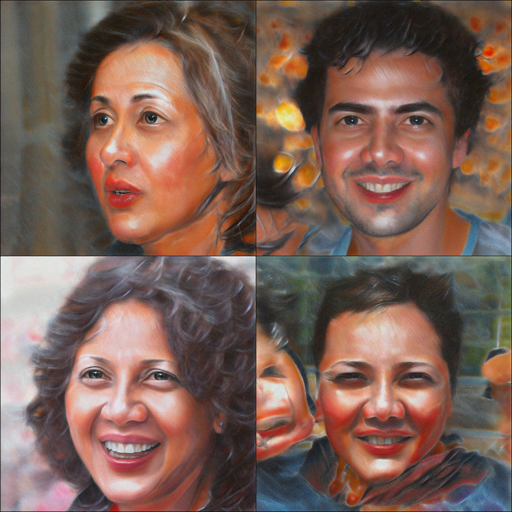

История обучения сохранена: /content/output/oil_painting_style_freeze_4/training_history.json
График сходимости сохранен: /content/output/oil_painting_style_freeze_4/convergence_plot.png
Модель сохранена: /content/output/oil_painting_style_freeze_4/final_model_oil_painting_style_freeze_4.pt
Размер файла: 126.59 MB
Финальный loss: 0.8184
Модель сохранена: /content/output/oil_painting_style_freeze_4/final_model_oil_painting_style_freeze_4.pt
Размер файла: 126.59 MB
Финальный loss: 0.8184
Обучение всех моделей завершено!
Всего обучено моделей: 12


In [9]:
print("Запуск цикла обучения по всем конфигурациям")

all_results = {}
model_paths = {}

for idx, config in enumerate(experiment_configs):
    target_class = config['target_class']
    exp_name = config['exp_name']
    freeze_layers = config['freeze_layers']

    net, history, exp_output_dir, args, exp_name_with_freeze = train_single_model(
        target_class=target_class,
        exp_name=exp_name,
        idx=idx,
        freeze_layers_k=freeze_layers
    )

    final_model_path = os.path.join(exp_output_dir, f"final_model_{exp_name_with_freeze.replace(' ', '_').lower()}.pt")

    metadata = {
        'history': history,
        'source_class': source_class,
        'target_class': target_class,
        'experiment_name': exp_name_with_freeze,
        'freeze_layers': freeze_layers,
        'sample_truncation': args.sample_truncation,
        'training_iterations': training_iterations,
        'final_loss': history['loss'][-1] if history['loss'] else None,
        'training_info': {
            'source_class': source_class,
            'target_class': target_class,
            'history': history,
            'freeze_layers': freeze_layers
        }
    }

    torch.save({
        'generator_state_dict': net.generator_trainable.state_dict(),
        'metadata': metadata
    }, final_model_path)

    file_size = os.path.getsize(final_model_path) / (1024 * 1024)
    print(f"Модель сохранена: {final_model_path}")
    print(f"Размер файла: {file_size:.2f} MB")
    print(f"Финальный loss: {history['loss'][-1]:.4f}")

    all_results[exp_name_with_freeze] = {
        'generator': net.generator_trainable,
        'history': history,
        'target_class': target_class,
        'freeze_layers': freeze_layers
    }
    model_paths[exp_name_with_freeze] = final_model_path

    del net
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if idx < len(experiment_configs) - 1:
        import time
        print(f"Завершен эксперимент {idx+1}/{len(experiment_configs)}")
        print("Пауза перед следующим экспериментом")
        time.sleep(3)

print("Обучение всех моделей завершено!")
print(f"Всего обучено моделей: {len(model_paths)}")

## Оценка качества

In [10]:
def evaluate_all_models():
    print("Оценка качества моделей:")

    metrics_table = []
    best_model_by_style = {}

    for exp_base_name in experiment_names:
        best_model_for_style = None
        best_cos_sim_for_style = -1

        for freeze_layers in freeze_options:
            exp_name_with_freeze = f"{exp_base_name}_freeze_{freeze_layers}"
            exp_dir = os.path.join(output_dir, exp_name_with_freeze.replace(" ", "_").lower())

            if os.path.exists(exp_dir):
                model_path = os.path.join(exp_dir, f"final_model_{exp_name_with_freeze.replace(' ', '_').lower()}.pt")
                model_exists = os.path.exists(model_path)

                metrics = {
                    'model': exp_name_with_freeze.upper(),
                    'base_model': exp_base_name.upper(),
                    'freeze_layers': freeze_layers,
                    'path': exp_dir,
                    'model_exists': model_exists,
                    'size_mb': 0,
                    'final_loss': None,
                    'avg_loss': None,
                    'min_loss': None,
                    'convergence_step': None,
                    'target_class': None,
                    'samples_count': 0,
                    'cos_sim': None,
                    'history': None,
                }

                if model_exists:
                    try:
                        checkpoint = torch.load(model_path, map_location='cpu')

                        if 'metadata' in checkpoint:
                            metadata = checkpoint['metadata']

                            history_file = os.path.join(exp_dir, "training_history.json")
                            if os.path.exists(history_file):
                                with open(history_file, 'r', encoding='utf-8') as f:
                                    training_history = json.load(f)
                                    metrics['history'] = training_history

                                    if 'loss' in training_history and len(training_history['loss']) > 0:
                                        losses = training_history['loss']
                                        metrics['final_loss'] = losses[-1]
                                        metrics['avg_loss'] = sum(losses) / len(losses)
                                        metrics['min_loss'] = min(losses)

                                        if len(losses) > 100:
                                            for i in range(100, len(losses)):
                                                window = losses[max(0, i-10):i]
                                                if max(window) - min(window) < 0.01:
                                                    metrics['convergence_step'] = i
                                                    break
                            else:
                                if 'history' in metadata:
                                    metrics['history'] = metadata['history']
                                    losses = metadata['history'].get('loss', [])
                                    if losses:
                                        metrics['final_loss'] = losses[-1]
                                        metrics['avg_loss'] = sum(losses) / len(losses)
                                        metrics['min_loss'] = min(losses)

                            if 'final_loss' in metadata and metrics['final_loss'] is None:
                                metrics['final_loss'] = metadata['final_loss']

                            if 'target_class' in metadata:
                                metrics['target_class'] = metadata['target_class']

                            if metrics['final_loss'] is not None:
                                cos_sim = 1 - metrics['final_loss']
                                metrics['cos_sim'] = cos_sim

                                if cos_sim > best_cos_sim_for_style:
                                    best_cos_sim_for_style = cos_sim
                                    best_model_for_style = exp_name_with_freeze

                        metrics['size_mb'] = os.path.getsize(model_path) / (1024 * 1024)

                        sample_dir = os.path.join(exp_dir, "sample")
                        if os.path.exists(sample_dir):
                            grid_files = [f for f in os.listdir(sample_dir) if f.startswith('dst_')]
                            metrics['samples_count'] = len(grid_files)

                    except Exception as e:
                        print(f"Ошибка при загрузке модели {exp_name_with_freeze}: {e}")
                        metrics['error'] = str(e)

                metrics_table.append(metrics)

        if best_model_for_style:
            best_model_by_style[exp_base_name] = {
                'model_name': best_model_for_style,
                'cos_sim': best_cos_sim_for_style
            }

    return metrics_table, best_model_by_style

In [11]:
metrics_table, best_model_by_style = evaluate_all_models()

from collections import defaultdict
results_by_style = defaultdict(list)

for metrics in metrics_table:
    if metrics['model_exists'] and metrics['base_model']:
        results_by_style[metrics['base_model']].append(metrics)

print("Результаты по стилям:")

for style in experiment_names:
    style_upper = style.upper()
    if style_upper in results_by_style:
        print(f"\n{style_upper}:")

        models_for_style = results_by_style[style_upper]
        models_for_style.sort(key=lambda x: x['freeze_layers'])

        for metrics in models_for_style:
            if not metrics['model_exists']:
                continue

            print(f"\nКонфигурация: {metrics['model']}")
            print(f"  Заморожено слоев: {metrics['freeze_layers']}")

            if metrics['final_loss'] is not None:
                print(f"  Финальный loss: {metrics['final_loss']:.4f}")
                print(f"  Cosine similarity: {metrics.get('cos_sim', 0):.4f}")

                if metrics['convergence_step']:
                    convergence_percentage = (metrics['convergence_step'] / training_iterations) * 100
                    print(f"  Сходимость на шаге: {metrics['convergence_step']} ({convergence_percentage:.1f}%)")

            print(f"  Размер модели: {metrics['size_mb']:.2f} MB")
            print(f"  Сэмплов: {metrics['samples_count']}")

        if style in best_model_by_style:
            best_info = best_model_by_style[style]
            print(f"\nЛучшая конфигурация для {style_upper}:")
            print(f"     Модель: {best_info['model_name']}")
            print(f"     Cosine similarity: {best_info['cos_sim']:.4f}")

Оценка качества моделей:
Результаты по стилям:

ANIME_STYLE:

Конфигурация: ANIME_STYLE_FREEZE_0
  Заморожено слоев: 0
  Финальный loss: 0.8628
  Cosine similarity: 0.1372
  Размер модели: 126.59 MB
  Сэмплов: 13

Конфигурация: ANIME_STYLE_FREEZE_2
  Заморожено слоев: 2
  Финальный loss: 0.8149
  Cosine similarity: 0.1851
  Размер модели: 126.59 MB
  Сэмплов: 13

Конфигурация: ANIME_STYLE_FREEZE_4
  Заморожено слоев: 4
  Финальный loss: 0.8350
  Cosine similarity: 0.1650
  Размер модели: 126.59 MB
  Сэмплов: 13

Лучшая конфигурация для ANIME_STYLE:
     Модель: anime_style_freeze_2
     Cosine similarity: 0.1851

SKETCH_STYLE:

Конфигурация: SKETCH_STYLE_FREEZE_0
  Заморожено слоев: 0
  Финальный loss: 0.8325
  Cosine similarity: 0.1675
  Размер модели: 126.59 MB
  Сэмплов: 13

Конфигурация: SKETCH_STYLE_FREEZE_2
  Заморожено слоев: 2
  Финальный loss: 0.8398
  Cosine similarity: 0.1602
  Размер модели: 126.59 MB
  Сэмплов: 13

Конфигурация: SKETCH_STYLE_FREEZE_4
  Заморожено слоев: 4


In [12]:
successful_models = [m for m in metrics_table if m['model_exists'] and m['final_loss'] is not None]

if successful_models:
    freeze_stats = defaultdict(list)
    for model in successful_models:
        freeze_stats[model['freeze_layers']].append(model.get('cos_sim', 0))

    print(f"Всего обучено моделей: {len(successful_models)}/{len(metrics_table)}")

    if successful_models:
        avg_loss = sum(m['final_loss'] for m in successful_models) / len(successful_models)
        avg_cos_sim = sum(m.get('cos_sim', 0) for m in successful_models) / len(successful_models)
        total_size = sum(m['size_mb'] for m in successful_models)

        print(f"Средний финальный loss: {avg_loss:.4f}")
        print(f"Средний cosine similarity: {avg_cos_sim:.4f}")
        print(f"Общий размер всех моделей: {total_size:.2f} MB")

    print(f"\nСтатистика по вариантам заморозки:")
    for freeze_layers in sorted(freeze_stats.keys()):
        cos_sims = freeze_stats[freeze_layers]
        if cos_sims:
            avg_cos = sum(cos_sims) / len(cos_sims)
            print(f"  Заморозка {freeze_layers} слоев: {len(cos_sims)} моделей, средний cos_sim: {avg_cos:.4f}")

detailed_info = {
    'summary': {
        'total_experiments': len(metrics_table),
        'successful_models': len(successful_models) if successful_models else 0,
        'best_models_by_style': best_model_by_style,
        'freeze_options': freeze_options
    },
    'models': {},
    'statistics': {
        'avg_loss': avg_loss if successful_models else None,
        'avg_cos_sim': avg_cos_sim if successful_models else None,
        'total_size_mb': total_size if successful_models else None,
        'freeze_stats': dict(freeze_stats)
    }
}

for metrics in metrics_table:
    if metrics['model_exists']:
        detailed_info['models'][metrics['model']] = {
            'exists': metrics['model_exists'],
            'base_model': metrics['base_model'],
            'freeze_layers': metrics['freeze_layers'],
            'size_mb': metrics['size_mb'],
            'final_loss': metrics['final_loss'],
            'cos_sim': metrics.get('cos_sim'),
            'target_class': metrics['target_class'],
            'samples_count': metrics['samples_count'],
            'convergence_step': metrics.get('convergence_step'),
            'error': metrics.get('error')
        }

detailed_info_path = os.path.join(output_dir, "detailed_metrics_all_experiments.json")
with open(detailed_info_path, 'w', encoding='utf-8') as f:
    json.dump(detailed_info, f, indent=2, ensure_ascii=False)

print(f"Подробный отчет сохранен: {detailed_info_path}")

Всего обучено моделей: 12/12
Средний финальный loss: 0.8179
Средний cosine similarity: 0.1821
Общий размер всех моделей: 1519.12 MB

Статистика по вариантам заморозки:
  Заморозка 0 слоев: 4 моделей, средний cos_sim: 0.1747
  Заморозка 2 слоев: 4 моделей, средний cos_sim: 0.1960
  Заморозка 4 слоев: 4 моделей, средний cos_sim: 0.1757
Подробный отчет сохранен: /content/output/detailed_metrics_all_experiments.json


In [15]:
def analyze_results_and_draw_conclusions():
    analysis_results = {
        'by_style': defaultdict(dict),
        'by_freeze': defaultdict(list),
        'overall_stats': {},
        'recommendations': []
    }

    # анализ по стилям
    for style in experiment_names:
        style_models = []
        for metrics in metrics_table:
            if metrics.get('base_model') == style.upper() and metrics['model_exists']:
                style_models.append(metrics)

        if not style_models:
            continue

        style_models.sort(key=lambda x: x.get('cos_sim', 0), reverse=True)

        best_for_style = style_models[0]

        analysis_results['by_style'][style] = {
            'best_model': best_for_style['model'],
            'best_cos_sim': best_for_style.get('cos_sim', 0),
            'best_freeze': best_for_style['freeze_layers'],
            'num_configs': len(style_models),
            'freeze_stats': {}
        }

        # анализ по вариантам заморозки
        for model in style_models:
            if model.get('cos_sim'):
                analysis_results['by_freeze'][model['freeze_layers']].append(model['cos_sim'])

        freeze_stats = {}
        for model in style_models:
            freeze = model['freeze_layers']
            if freeze not in freeze_stats:
                freeze_stats[freeze] = []
            if model.get('cos_sim'):
                freeze_stats[freeze].append(model['cos_sim'])

        analysis_results['by_style'][style]['freeze_stats'] = freeze_stats

    best_freeze_overall = None
    best_avg_cos_sim = -1

    for freeze_layers in sorted(analysis_results['by_freeze'].keys()):
        cos_sims = analysis_results['by_freeze'][freeze_layers]
        if cos_sims:
            avg_cos = sum(cos_sims) / len(cos_sims)
            if avg_cos > best_avg_cos_sim:
                best_avg_cos_sim = avg_cos
                best_freeze_overall = freeze_layers

    successful_models = [m for m in metrics_table if m['model_exists'] and m['final_loss'] is not None]

    if successful_models:
        all_cos_sims = [m.get('cos_sim', 0) for m in successful_models if m.get('cos_sim')]

        analysis_results['overall_stats'] = {
            'total_models': len(successful_models),
            'avg_cos_sim': sum(all_cos_sims) / len(all_cos_sims) if all_cos_sims else 0,
            'max_cos_sim': max(all_cos_sims) if all_cos_sims else 0,
            'min_cos_sim': min(all_cos_sims) if all_cos_sims else 0,
            'best_freeze_overall': best_freeze_overall,
            'best_avg_cos_sim': best_avg_cos_sim
        }

    return analysis_results

In [13]:
def visualize_results():

    vis_dir = os.path.join(output_dir, "visualizations")
    os.makedirs(vis_dir, exist_ok=True)

    # качество по стилям
    plt.figure(figsize=(12, 6))

    styles = []
    best_cos_sims = []
    best_freeze_configs = []

    for style in experiment_names:
        if style in analysis_results['by_style']:
            info = analysis_results['by_style'][style]
            styles.append(style.upper())
            best_cos_sims.append(info['best_cos_sim'])
            best_freeze_configs.append(f"Freeze {info['best_freeze']}")

    x = np.arange(len(styles))
    width = 0.6

    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.bar(x, best_cos_sims, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])

    ax.set_xlabel('Стиль', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
    ax.set_title('Качество адаптации по стилям', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(styles)
    ax.set_ylim(0, 1.0)

    for i, (bar, freeze) in enumerate(zip(bars, best_freeze_configs)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}\n({freeze})',
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plot_path1 = os.path.join(vis_dir, "quality_by_style.png")
    plt.savefig(plot_path1, dpi=150, bbox_inches='tight')
    print(f"График качества по стилям сохранен: {plot_path1}")

    # влияние заморозки
    plt.figure(figsize=(10, 6))

    freeze_levels = sorted(analysis_results['by_freeze'].keys())
    avg_cos_by_freeze = []
    std_cos_by_freeze = []

    for freeze in freeze_levels:
        cos_sims = analysis_results['by_freeze'][freeze]
        if cos_sims:
            avg_cos_by_freeze.append(sum(cos_sims) / len(cos_sims))
            std_cos_by_freeze.append(np.std(cos_sims) if len(cos_sims) > 1 else 0)
        else:
            avg_cos_by_freeze.append(0)
            std_cos_by_freeze.append(0)

    fig, ax = plt.subplots(figsize=(10, 6))
    x_pos = np.arange(len(freeze_levels))

    bars = ax.bar(x_pos, avg_cos_by_freeze, yerr=std_cos_by_freeze,
                  capsize=5, color='#6A5ACD', alpha=0.7)

    ax.set_xlabel('Количество замороженных слоев', fontsize=12, fontweight='bold')
    ax.set_ylabel('Средний Cosine Similarity', fontsize=12, fontweight='bold')
    ax.set_title('Влияние заморозки слоев на качество', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'Freeze {f}' for f in freeze_levels])
    ax.set_ylim(0, 1.0)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        count = len(analysis_results['by_freeze'][freeze_levels[i]])
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}\n(n={count})',
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plot_path2 = os.path.join(vis_dir, "effect_of_freeze.png")
    plt.savefig(plot_path2, dpi=150, bbox_inches='tight')
    print(f"График влияния заморозки сохранен: {plot_path2}")

    # качество по стилям и заморозке (heatmap)
    plt.figure(figsize=(12, 8))

    heatmap_data = np.zeros((len(experiment_names), len(freeze_options)))

    for i, style in enumerate(experiment_names):
        for j, freeze in enumerate(freeze_options):
            model_found = False
            for metrics in metrics_table:
                if (metrics.get('base_model') == style.upper() and
                    metrics['freeze_layers'] == freeze and
                    metrics.get('cos_sim') is not None):
                    heatmap_data[i, j] = metrics['cos_sim']
                    model_found = True
                    break

            if not model_found:
                heatmap_data[i, j] = np.nan

    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(heatmap_data, cmap='RdYlGn', vmin=0, vmax=1.0, aspect='auto')

    ax.set_xticks(np.arange(len(freeze_options)))
    ax.set_yticks(np.arange(len(experiment_names)))
    ax.set_xticklabels([f'Freeze {f}' for f in freeze_options])
    ax.set_yticklabels([s.upper() for s in experiment_names])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(experiment_names)):
        for j in range(len(freeze_options)):
            if not np.isnan(heatmap_data[i, j]):
                text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                              ha="center", va="center", color="black", fontsize=10)

    ax.set_title("Качество адаптации по стилям и вариантам заморозки", fontsize=14, fontweight='bold')
    fig.colorbar(im, ax=ax, label='Cosine Similarity')
    plt.tight_layout()

    plot_path3 = os.path.join(vis_dir, "quality_heatmap.png")
    plt.savefig(plot_path3, dpi=150, bbox_inches='tight')
    print(f"Heatmap качества сохранен: {plot_path3}")

    print("\nСоздание графиков сходимости для лучших моделей...")

    convergence_dir = os.path.join(vis_dir, "convergence_plots")
    os.makedirs(convergence_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    plots_created = 0

    for idx, style in enumerate(experiment_names):
        if idx >= len(axes):
            break

        ax = axes[idx]

        if style in analysis_results['by_style']:
            best_model_name = analysis_results['by_style'][style]['best_model']

            model_history = None
            model_metrics = None

            for metrics in metrics_table:
                if metrics['model'] == best_model_name.upper():
                    model_metrics = metrics
                    break

            if model_metrics and model_metrics.get('history'):
                history = model_metrics['history']
                if 'loss' in history and history['loss'] and len(history['loss']) > 0:
                    losses = history['loss']
                    steps = list(range(len(losses)))

                    ax.plot(steps, losses, 'b-', linewidth=1.5, alpha=0.7)
                    ax.set_title(f'{style.upper()} (Freeze {analysis_results["by_style"][style]["best_freeze"]})',
                               fontsize=11, fontweight='bold')
                    ax.set_xlabel('Итерация', fontsize=10)
                    ax.set_ylabel('Loss', fontsize=10)
                    ax.grid(True, alpha=0.3)

                    final_loss = losses[-1] if losses else 0
                    ax.text(0.95, 0.95, f'Final: {final_loss:.4f}',
                           transform=ax.transAxes, ha='right', va='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                           fontsize=9)

                    if len(losses) > 100:
                        convergence_point = None
                        for i in range(100, len(losses)):
                            window = losses[max(0, i-10):i]
                            if max(window) - min(window) < 0.01:
                                convergence_point = i
                                ax.axvline(x=convergence_point, color='r', linestyle='--',
                                         alpha=0.5, linewidth=1)
                                ax.text(convergence_point, ax.get_ylim()[1]*0.9,
                                       f'Conv: {convergence_point}',
                                       ha='center', va='top', fontsize=8, color='red')
                                break

                    plots_created += 1

                    create_individual_convergence_plot(
                        style, best_model_name, history,
                        analysis_results["by_style"][style]["best_freeze"],
                        convergence_dir
                    )

                else:
                    ax.text(0.5, 0.5, f'Нет данных потерь\nдля {style.upper()}',
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{style.upper()} (нет данных loss)')
                    ax.set_xlabel('Итерация')
                    ax.set_ylabel('Loss')
            else:
                history_file = None
                for freeze in freeze_options:
                    exp_name_with_freeze = f"{style}_freeze_{freeze}"
                    exp_dir = os.path.join(output_dir, exp_name_with_freeze.replace(" ", "_").lower())
                    history_path = os.path.join(exp_dir, "training_history.json")
                    if os.path.exists(history_path):
                        history_file = history_path
                        break

                if history_file:
                    try:
                        with open(history_file, 'r', encoding='utf-8') as f:
                            history = json.load(f)

                        if 'loss' in history and history['loss'] and len(history['loss']) > 0:
                            losses = history['loss']
                            steps = list(range(len(losses)))

                            ax.plot(steps, losses, 'b-', linewidth=1.5, alpha=0.7)
                            ax.set_title(f'{style.upper()} (данные из файла)',
                                       fontsize=11, fontweight='bold')
                            ax.set_xlabel('Итерация', fontsize=10)
                            ax.set_ylabel('Loss', fontsize=10)
                            ax.grid(True, alpha=0.3)

                            final_loss = losses[-1] if losses else 0
                            ax.text(0.95, 0.95, f'Final: {final_loss:.4f}',
                                   transform=ax.transAxes, ha='right', va='top',
                                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                   fontsize=9)

                            plots_created += 1
                        else:
                            ax.text(0.5, 0.5, f'Файл истории пуст\n{style.upper()}',
                                   ha='center', va='center', transform=ax.transAxes)
                            ax.set_title(f'{style.upper()}')
                    except Exception as e:
                        ax.text(0.5, 0.5, f'Ошибка загрузки\n{style.upper()}\n{e}',
                               ha='center', va='center', transform=ax.transAxes)
                        ax.set_title(f'{style.upper()}')
                else:
                    ax.text(0.5, 0.5, f'Нет истории обучения\nдля {style.upper()}',
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{style.upper()}')
                    ax.set_xlabel('Итерация')
                    ax.set_ylabel('Loss')
        else:
            ax.text(0.5, 0.5, f'Нет данных\nдля {style.upper()}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{style.upper()}')
            ax.set_xlabel('Итерация')
            ax.set_ylabel('Loss')

    plt.tight_layout()
    plot_path4 = os.path.join(vis_dir, "convergence_best_models.png")
    plt.savefig(plot_path4, dpi=150, bbox_inches='tight')

    if plots_created > 0:
        print(f"График сходимости сохранен: {plot_path4}")
        print(f"Создано графиков: {plots_created} из {len(experiment_names)}")
    else:
        print(f"График сходимости создан, но данные отсутствуют")

    plt.close('all')

    print("\nСоздание детальных графиков для каждого стиля...")
    create_detailed_style_plots(metrics_table, experiment_names, freeze_options, vis_dir)

    print(f"\nВсе визуализации сохранены в: {vis_dir}")
    if os.path.exists(convergence_dir):
        print(f"Отдельные графики сходимости сохранены в: {convergence_dir}")

def create_individual_convergence_plot(style, model_name, history, freeze_layers, output_dir):
    if not history or 'loss' not in history or not history['loss']:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    losses = history['loss']
    steps = list(range(len(losses)))

    ax1.plot(steps, losses, 'b-', linewidth=1, alpha=0.7)
    ax1.set_title(f'{style.upper()} - Loss History\n{model_name}', fontsize=10, fontweight='bold')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    if len(losses) > 10:
        window_size = min(20, len(losses) // 10)
        smoothed = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        smoothed_steps = steps[window_size-1:]

        ax2.plot(smoothed_steps, smoothed, 'g-', linewidth=2)
        ax2.set_title(f'Smoothed (window={window_size})', fontsize=10, fontweight='bold')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Smoothed Loss')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    safe_model_name = model_name.replace('/', '_').replace('\\', '_').replace(':', '_')
    plot_path = os.path.join(output_dir, f"convergence_{safe_model_name}.png")
    plt.savefig(plot_path, dpi=120, bbox_inches='tight')
    plt.close()

def create_detailed_style_plots(metrics_table, experiment_names, freeze_options, vis_dir):

    for style in experiment_names:
        style_upper = style.upper()

        style_models = []
        for metrics in metrics_table:
            if metrics.get('base_model') == style_upper and metrics.get('history'):
                style_models.append(metrics)

        if len(style_models) > 1:
            fig, ax = plt.subplots(figsize=(10, 6))

            style_models.sort(key=lambda x: x.get('freeze_layers', 0))

            colors = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-']

            for i, model_metrics in enumerate(style_models):
                if i >= len(colors):
                    break

                history = model_metrics.get('history')
                if history and 'loss' in history and history['loss']:
                    losses = history['loss']
                    steps = list(range(len(losses)))
                    freeze = model_metrics.get('freeze_layers', 0)
                    final_loss = losses[-1] if losses else 0

                    ax.plot(steps, losses, colors[i], linewidth=1, alpha=0.7,
                           label=f'Freeze {freeze} (final: {final_loss:.4f})')

            ax.set_title(f'{style_upper} - Сравнение конфигураций', fontsize=12, fontweight='bold')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

            plt.tight_layout()
            plot_path = os.path.join(vis_dir, f"comparison_{style}.png")
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            plt.close()
            print(f"График сравнения для {style_upper}")

In [16]:
analysis_results = analyze_results_and_draw_conclusions()

visualize_results()



Анализ результатов и выводы:
График качества по стилям сохранен: /content/output/visualizations/quality_by_style.png
График влияния заморозки сохранен: /content/output/visualizations/effect_of_freeze.png
Heatmap качества сохранен: /content/output/visualizations/quality_heatmap.png

Создание графиков сходимости для лучших моделей...
График сходимости сохранен: /content/output/visualizations/convergence_best_models.png
Создано графиков: 4 из 4

Создание детальных графиков для каждого стиля...
График сравнения для ANIME_STYLE
График сравнения для SKETCH_STYLE
График сравнения для JOKER_STYLE
График сравнения для OIL_PAINTING_STYLE

Все визуализации сохранены в: /content/output/visualizations
Отдельные графики сходимости сохранены в: /content/output/visualizations/convergence_plots


## Результаты и выводы  

**Реализовано:**

- direction loss: косинусное расстояние между направлениями в CLIP пространстве
- цикл обучения с заморозкой последних k слоев и с использованием ансамбля из трех CLIP-моделей с разными весами
- обучение и сохранение моделей для генерации картинок в разных стилях

**Не реализовано:**

- latent regularization
- image-to-image режим (только text-to-image)
- эксперименты с разными конфигурациями заморозки
- применение стилизаций к реальному изображению


**Настройки обучения**  
- базовая модель: StyleGAN2 FFHQ (1024×1024)
- CLIP модели: ансамбль из ViT-B/32, ViT-B/16, ViT-L/14
- веса CLIP: [0.4, 0.1, 0.5]
- learning rate: 0.002
- итерации: 600
- batch size: 2

**Метрики**    

Успех адаптации оценивается по:
- косинусному сходству: соответствие направления между изображениями направлению между текстами
- визуальному качеству: сохранение узнаваемости лица при применении стиля
- специфичности стиля: насколько четко проявляются характерные черты целевого стиля

**Что получилось лучше всего**   

Стиль Джокера и картина маслом — визуально наилучший результат (сохранение структуры лица при четкой стилизации, хорошее распознавание характерных черт персонажа).

Вероятно, это связано с тем, что в этих случаях применяется наиболее выраженная трансформация.
    
В скетч-стиле тоже неплохой результат: четкая имитация карандашной текстуры,сохранение деталей лица, естественные градиенты и тени.

**Какие были проблемы**     

Слабая стилизация в аниме-стиле

Первоначально я использовала одну CLIP модель, и наблюдалась генерация реалистичных лиц с минимальными аниме-чертами. После использования трех моделей с разными весами качество значительно улучшилось. Вероятно, стоит еще в этом месте поэкспериментировать с промптами.

Из-за ограниченности вычислительных ресурсов не удалось полноценно поэкспериментировать с заморозкой слоев и редактированием реального изображения.

**Заключение**    

В целом удалось реализовать креативную генерацию с помощью StyleGAN-NADA без необходимости сбора большого датасета.